In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date))\
    .first()[0]
print("Most recent date is:", most_recent_date)

Most recent date is: 2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_before_recent = '2016-08-23'

# Perform a query to retrieve the data and precipitation scores
year_in_review = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date.between(year_before_recent, most_recent_date))\
    .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_df = pd.DataFrame(year_in_review)
year_df = year_df.set_index("date")

# Sort the dataframe by date
year_df = year_df.sort_values('date')
year_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


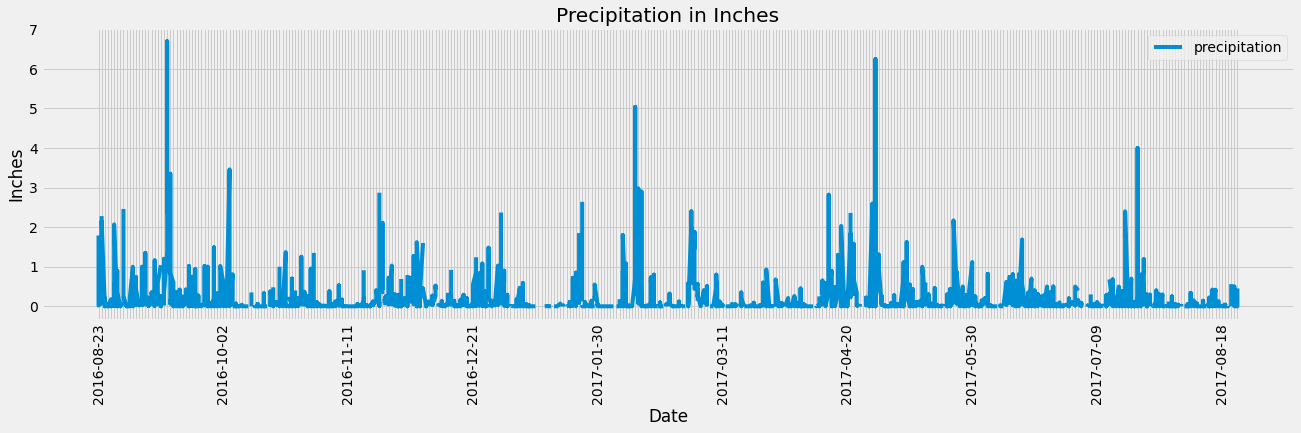

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(year_df.index.values, year_df['prcp'])
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.legend(["precipitation"], loc=1)
plt.xticks(rotation = 90)
plt.title("Precipitation in Inches")

#Show tick labels for every 40 entries
every_nth = 40
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summ_stats = year_df.describe()
summ_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
print("Total number of stations in this dataset:", total_stations)

Total number of stations in this dataset: 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

for station in most_active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]

lowest = session.query(Measurement.station, func.min(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .first()

highest = session.query(Measurement.station, func.max(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .first()

average = session.query(Measurement.station, func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .first()

print("The lowest temperature for", most_active_station, "is", lowest[1])
print("The highest temperature for", most_active_station, "is", highest[1])
print("The average temperature for", most_active_station, "is", round(average[1], 1))

The lowest temperature for USC00519281 is 54.0
The highest temperature for USC00519281 is 85.0
The average temperature for USC00519281 is 71.7


In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_year_in_review = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date.between(year_before_recent, most_recent_date))\
    .filter(Measurement.station == most_active_station)\
    .all()

active_df = pd.DataFrame(active_station_year_in_review)
active_df = active_df.set_index('date')
active_df.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


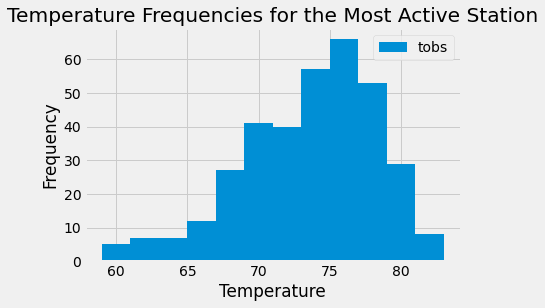

In [17]:
plt.hist(active_df["tobs"], bins=12)
plt.legend(["tobs"])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Frequencies for the Most Active Station")
plt.show()

# Close session

In [18]:
# Close Session
session.close()